In [1]:
import pandas as pd
import pytz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# EXTRACTION
df_traj = pd.read_csv("trip_traj.csv")
df_od = pd.read_csv("trip_od.csv")
df_vo = pd.read_excel("JICA Tables.xlsx", sheet_name='Table 2.1.10')

print("TRIP OD")
display(df_od.head())
display(df_od.shape)
# display(df_traj.head())
# display(df_traj.shape)

# DATA CLEANING
column_rename = {'Unnamed: 0': 'index'}
df_traj = df_traj.rename(columns=column_rename)
df_od = df_od.rename(columns=column_rename)
df_od = df_od[['index', 'id', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'time', 'dt', 'distance', 'aver_speed']]

# Setting time
# df_od['time'] = pd.to_datetime(df_od['time'], unit='s')
# timezone = pytz.timezone('Etc/GMT+7')
# df_od['time'] = df_od['time'].dt.tz_localize(pytz.utc).dt.tz_convert(timezone)

print("TRIP OD")
display(df_od.head())
display(df_od.shape)

TRIP OD


,Unnamed: 0,id,start_lat,start_lon,end_lat,end_lon,path,time,dt,distance,aver_speed
0,82630,NjdxOTRxNzE5azl0YTo5a2JiMW9lcXFrY2dk,11.54902,104.91924,11.54807,104.93109,"149.0,150.0,151.0,152.0,153.0,154.0,155.0,156....",1689094803,676,2835.936342,4.195172
1,82631,OGppY242cWo4Zm90NjpmZ2JrcG81b2k0cTdq,11.55893,104.90146,11.56971,104.89853,"961.0,962.0,963.0,964.0,965.0,966.0,967.0,968....",1689094812,223,2752.782123,12.344314
2,82632,NGxjNTZiNWhtMW8yazo5dm1ybmpyZXY5dmNx,11.57772,104.88223,11.57468,104.88775,"1678.0,1679.0,1680.0,1681.0,1682.0,1683.0,1684...",1689094818,227,1366.980997,6.021943
3,82633,NmoxOXFidTE2NDE3dTpkajBxMWlzMWVyYWE1,11.59833,104.88362,11.60824,104.89405,"1028.0,1029.0",1689094842,610,1583.232169,2.595463
4,82634,NzEzazAzOGQ0b2hzbzpjY2N2NXNmY3N2ZWV0,11.62541,104.92467,11.63609,104.92019,"297.0,298.0,299.0,300.0,301.0",1689094879,429,1324.683042,3.087839


(44102, 11)

TRIP OD


,index,id,start_lat,start_lon,end_lat,end_lon,time,dt,distance,aver_speed
0,82630,NjdxOTRxNzE5azl0YTo5a2JiMW9lcXFrY2dk,11.54902,104.91924,11.54807,104.93109,1689094803,676,2835.936342,4.195172
1,82631,OGppY242cWo4Zm90NjpmZ2JrcG81b2k0cTdq,11.55893,104.90146,11.56971,104.89853,1689094812,223,2752.782123,12.344314
2,82632,NGxjNTZiNWhtMW8yazo5dm1ybmpyZXY5dmNx,11.57772,104.88223,11.57468,104.88775,1689094818,227,1366.980997,6.021943
3,82633,NmoxOXFidTE2NDE3dTpkajBxMWlzMWVyYWE1,11.59833,104.88362,11.60824,104.89405,1689094842,610,1583.232169,2.595463
4,82634,NzEzazAzOGQ0b2hzbzpjY2N2NXNmY3N2ZWV0,11.62541,104.92467,11.63609,104.92019,1689094879,429,1324.683042,3.087839


(44102, 10)

# Splitting the Data into 4 Shifts

Shift 1: 12 am <= time <= 7 am \
Shift 2: 7 am < time <= 11 am \
Shift 3: 11 am < time <= 4 pm \
Shift 4: 4 pm < time <= 12 am

July 12, 12am GMT+7     : 1689094800 \
July 12,  7am GMT+7     : 1689120000 \
July 12, 11am GMT+7     : 1689134400 \
July 12,  4pm GMT+7     : 1689159600 \
July 13, 12am GMT+7     : 1689181200

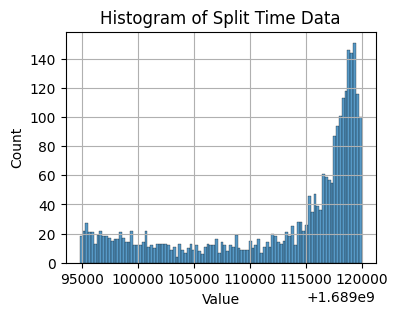

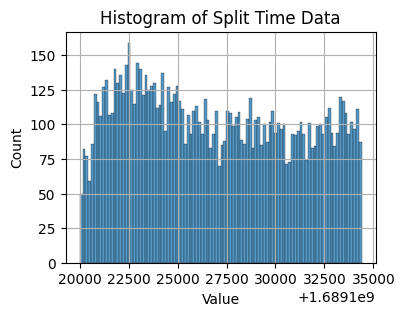

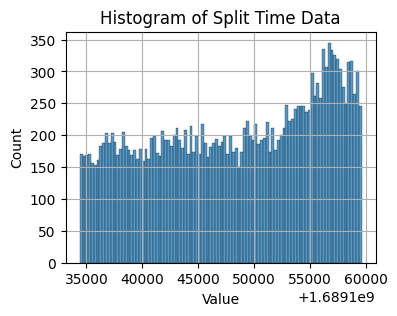

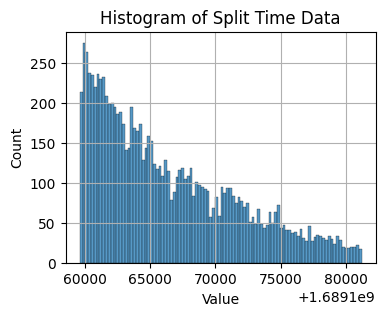

In [3]:
# SPLITTING 

df_shift1 = df_od.loc[ (df_od['time'] >= 1689094800) & (df_od['time'] <= 1689120000) ]
df_shift2 = df_od.loc[ (df_od['time'] > 1689120000) & (df_od['time'] <= 1689134400) ]
df_shift3 = df_od.loc[ (df_od['time'] > 1689134400) & (df_od['time'] <= 1689159600) ]
df_shift4 = df_od.loc[ (df_od['time'] > 1689159600) & (df_od['time'] <= 1689181200) ]
list_df = [df_shift1, df_shift2, df_shift3, df_shift4]

for df in list_df: 
    plt.figure(figsize=(4, 3))
    sns.histplot(x='time', data=df, bins=100) 
    plt.title('Histogram of Split Time Data')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()
    # display(df)

# Training the KDE

In [4]:
# 5D KDE PLOT
from scipy.stats import gaussian_kde
np.random.seed(42)  

total_length = sum(len(df) for df in list_df)

count = 0
for df in list_df: 
    start_lat = df['start_lat']
    start_lon = df['start_lon']
    end_lat = df['end_lat']
    end_lon = df['end_lon']
    time = df['time']
    coords = np.vstack([start_lat, start_lon, end_lat, end_lon, time])

    # Creating the 5D KDE model
    kde_5d = gaussian_kde(coords)

    # Generating the samples
    num_samples = int((2*10**6) * (len(df)/total_length))
    samples = kde_5d.resample(size=num_samples)

    if count == 0: 
        df_coordinates = pd.DataFrame(samples.T, columns=['start_lat', 'start_lon', 'end_lat', 'end_lon', 'time'])
        count += 1
    else: 
        df_to_append = pd.DataFrame(samples.T, columns=['start_lat', 'start_lon', 'end_lat', 'end_lon', 'time'])
        df_coordinates = pd.concat([df_coordinates, df_to_append], ignore_index=True)

# Evaluation & Visualization

### Coordinates

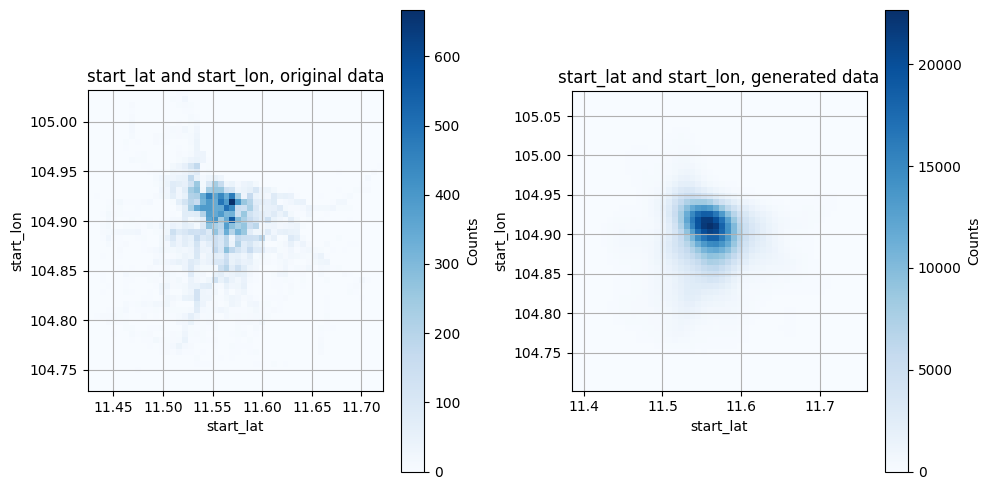

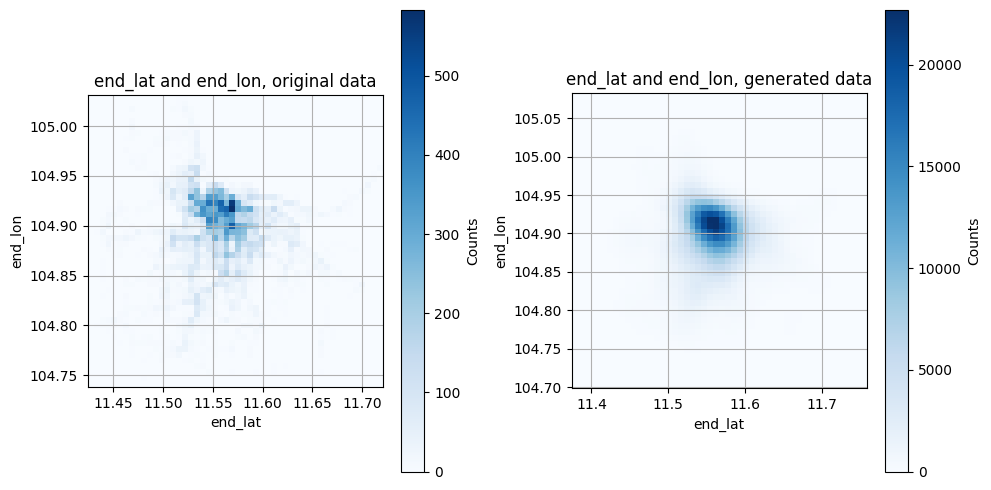

In [5]:
# DISPLAY: COMPARISON 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(df_od['start_lat'], df_od['start_lon'], bins=(50, 50), cmap=plt.cm.Blues)
axs[0].set_xlabel('start_lat')
axs[0].set_ylabel('start_lon')
axs[0].set_title('start_lat and start_lon, original data')
axs[0].grid(True)
axs[0].set_aspect('equal')  
axs[1].hist2d(df_coordinates['start_lat'], df_coordinates['start_lon'], bins=(50, 50), cmap=plt.cm.Blues)
axs[1].set_xlabel('start_lat')
axs[1].set_ylabel('start_lon')
axs[1].set_title('start_lat and start_lon, generated data')
axs[1].grid(True)
axs[1].set_aspect('equal')  

cbar1 = fig.colorbar(axs[0].collections[0], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(axs[1].collections[0], ax=axs[1], label='Counts')

plt.tight_layout()  
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(df_od['end_lat'], df_od['end_lon'], bins=(50, 50), cmap=plt.cm.Blues)
axs[0].set_xlabel('end_lat')
axs[0].set_ylabel('end_lon')
axs[0].set_title('end_lat and end_lon, original data')
axs[0].grid(True)
axs[0].set_aspect('equal')  
axs[1].hist2d(df_coordinates['end_lat'], df_coordinates['end_lon'], bins=(50, 50), cmap=plt.cm.Blues)
axs[1].set_xlabel('end_lat')
axs[1].set_ylabel('end_lon')
axs[1].set_title('end_lat and end_lon, generated data')
axs[1].grid(True)
axs[1].set_aspect('equal')  

cbar1 = fig.colorbar(axs[0].collections[0], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(axs[1].collections[0], ax=axs[1], label='Counts')

plt.tight_layout()  
plt.show()


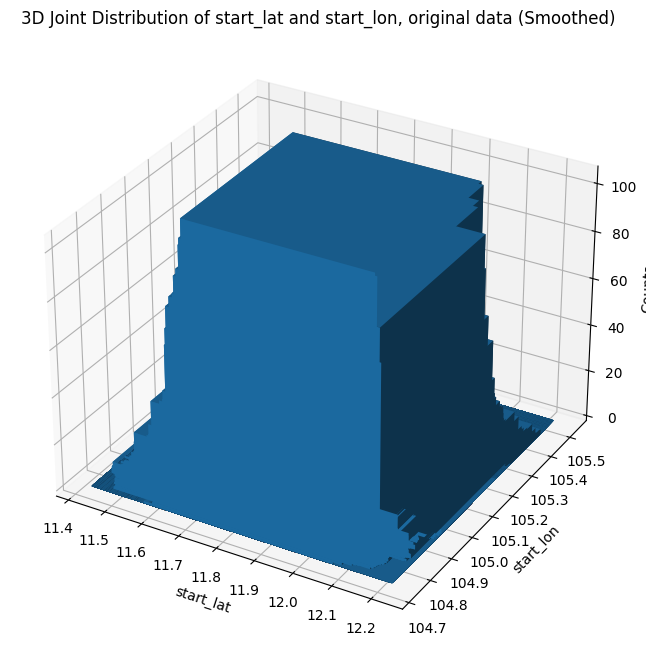

In [6]:
# DISPLAY: 3D VISUALIZATION
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(df_od['start_lat'], df_od['start_lon'], bins=(200, 200))
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1] - xedges[0]), 
                         yedges[:-1] + 0.5 * (yedges[1] - yedges[0]), 
                         indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', cmap=plt.cm.Blues)
ax.set_xlabel('start_lat')
ax.set_ylabel('start_lon')
ax.set_zlabel('Counts')
ax.set_title('3D Joint Distribution of start_lat and start_lon, original data (Smoothed)')

plt.show()

### Distance

In [7]:
# DISTANCE
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Calculate the distance
    R = 6371.0    
    distance = R * c
    return 1000 * distance #returns the distance in meters

df_coordinates['distance'] = float(0)

for i in range(len(df_coordinates)):
    start_lat, start_lon = df_coordinates.at[i, 'start_lat'], df_coordinates.at[i, 'start_lon']
    end_lat, end_lon = df_coordinates.at[i, 'end_lat'], df_coordinates.at[i, 'end_lon'] 
        
    df_coordinates.at[i,'distance'] = haversine(start_lat, start_lon, end_lat, end_lon)

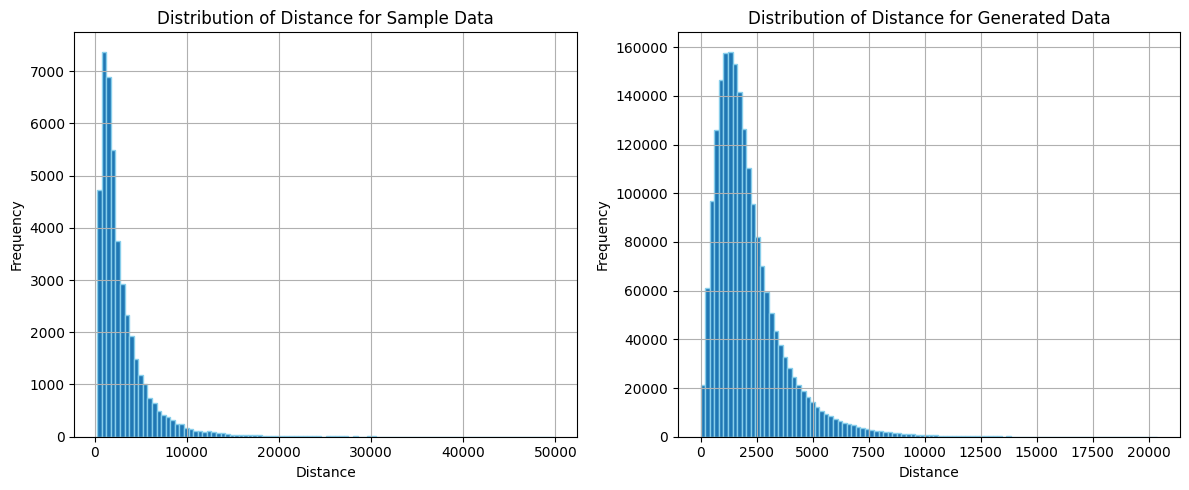

In [8]:
# COMPARISON
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

distance_samples = df_od['distance']
axs[0].hist(distance_samples, bins=100, edgecolor='skyblue')
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Distance for Sample Data')
axs[0].grid(True)

distance_generated = df_coordinates['distance']
axs[1].hist(distance_generated, bins=100, edgecolor='skyblue')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Distance for Generated Data')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

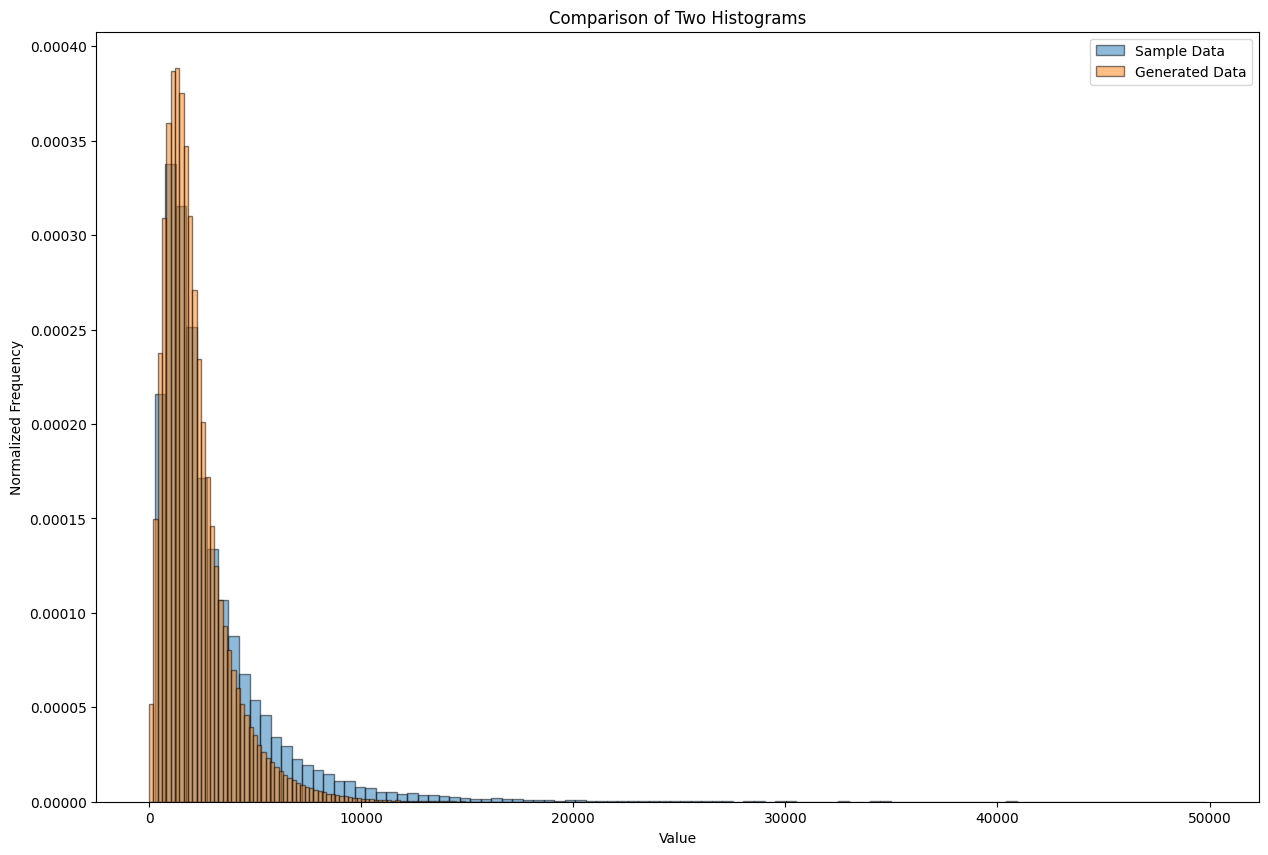

In [9]:
# NORMALIZED COMPARISON

data1 = distance_samples.tolist()
data2 = distance_generated.tolist()

# Calculate histograms with normalized frequencies
hist_data1, bin_edges1 = np.histogram(data1, bins=100, density=True)
hist_data2, bin_edges2 = np.histogram(data2, bins=100, density=True)

# Plot histograms
plt.figure(figsize=(15, 10))
plt.hist(bin_edges1[:-1], bin_edges1, weights=hist_data1, alpha=0.5, label='Sample Data', edgecolor='black')
plt.hist(bin_edges2[:-1], bin_edges2, weights=hist_data2, alpha=0.5, label='Generated Data', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Normalized Frequency')
plt.title('Comparison of Two Histograms')
plt.legend()
plt.show()

### Time

ORIGINAL DATA


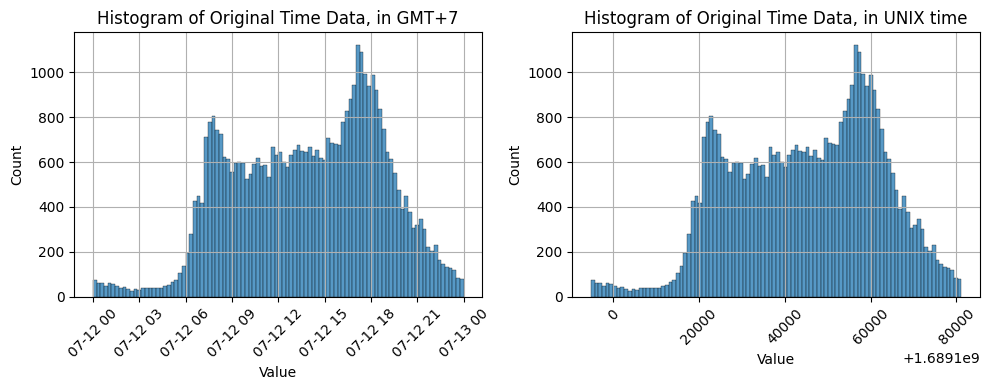

GENERATED DATA


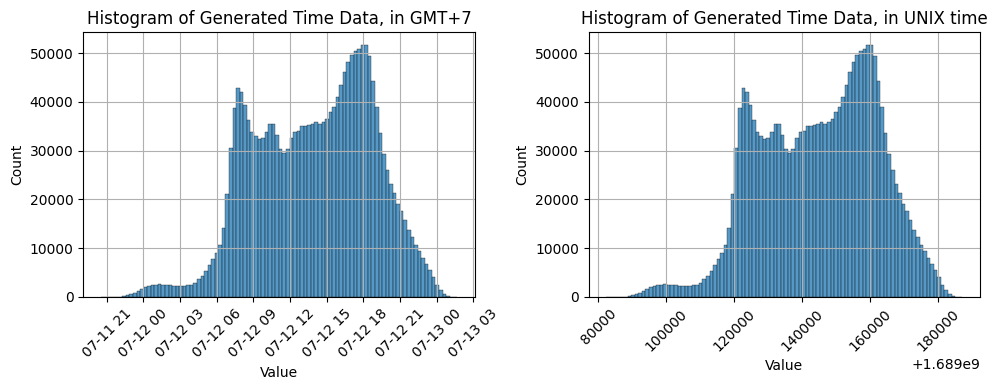

In [10]:
# DISPLAY: VISUALIZATION FOR GENERATED TIME DATA
from datetime import datetime, timedelta

def convert_unix_to_datetime(unix_timestamp):
    return datetime.utcfromtimestamp(unix_timestamp) + timedelta(hours=7)

df_od_visual = df_od[['time']].copy(deep=True)
df_od_visual['time'] = df_od_visual['time'].apply(convert_unix_to_datetime)
df_coordinates_visual = df_coordinates[['time']].copy(deep=True)
df_coordinates_visual['time'] = df_coordinates_visual['time'].apply(convert_unix_to_datetime)


# ORIGINAL DATA
print("ORIGINAL DATA")
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Datetime format 
sns.histplot(x='time', data=df_od_visual, bins=100, ax=axs[0]) 
axs[0].set_title('Histogram of Original Time Data, in GMT+7')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45) 
axs[0].grid(True)
# UNIX format
sns.histplot(x='time', data=df_od, bins=100, ax=axs[1]) 
axs[1].set_title('Histogram of Original Time Data, in UNIX time')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45) 
axs[1].grid(True)
# Display
plt.tight_layout()  
plt.show()

# GENERATED DATA 
print("GENERATED DATA")
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Datetime format 
sns.histplot(x='time', data=df_coordinates_visual, bins=100, ax=axs[0]) 
axs[0].set_title('Histogram of Generated Time Data, in GMT+7')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45) 
axs[0].grid(True)
# UNIX format
sns.histplot(x='time', data=df_coordinates, bins=100, ax=axs[1]) 
axs[1].set_title('Histogram of Generated Time Data, in UNIX time')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45) 
axs[1].grid(True)
# Display
plt.tight_layout()  
plt.show()

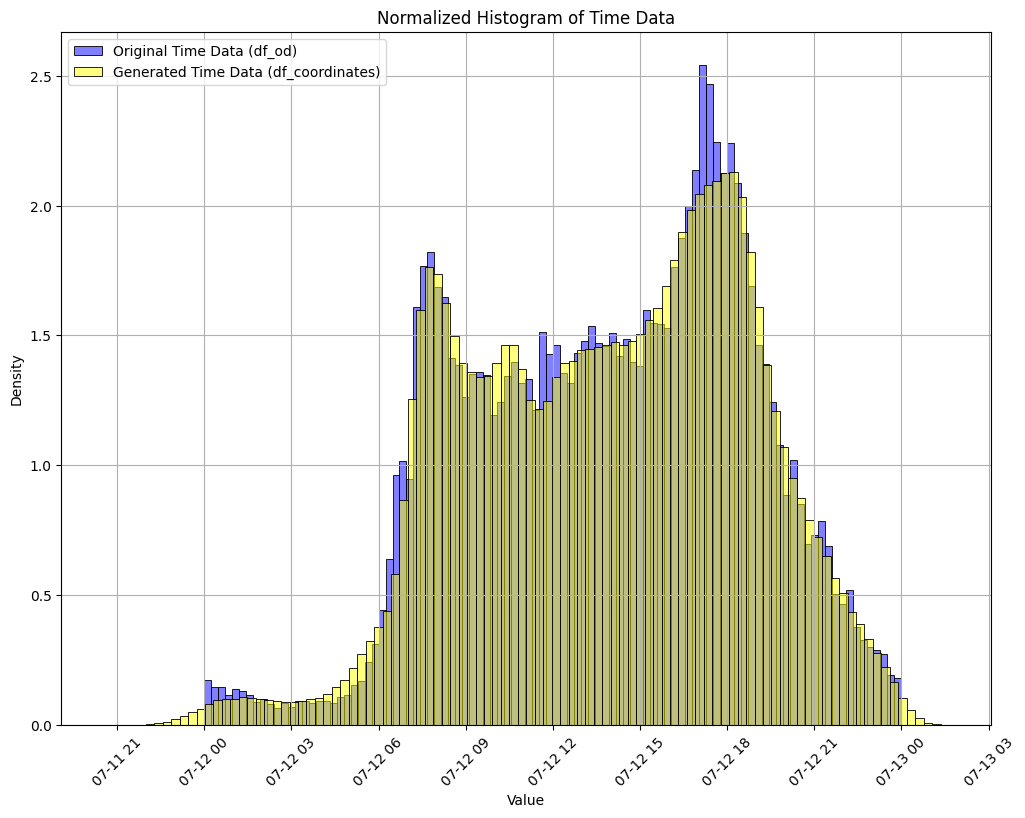

In [11]:
# NORMALIZED VIEW 

plt.figure(figsize=(12, 9))
sns.histplot(x='time', data=df_od_visual, bins=100, color='blue', label='Original Time Data (df_od)', alpha=0.5, stat='density')
sns.histplot(x='time', data=df_coordinates_visual, bins=100, color='yellow', label='Generated Time Data (df_coordinates)', alpha=0.5, stat='density')

plt.title('Normalized Histogram of Time Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend() 
plt.show()

# Exporting

In [12]:
df_coordinates.to_csv("Method 4//Version 0//Activity Plan - Method 4.csv")

In [13]:
df_final_part_1 = df_coordinates.iloc[:500000]
df_final_part_2 = df_coordinates.iloc[500000:1000000]
df_final_part_3 = df_coordinates.iloc[1000000:1500000]
df_final_part_4 = df_coordinates.iloc[1500000:]

df_final_part_1.to_csv("Method 4//Version 0//Activity Plan - Method 4 Part 1.csv")
df_final_part_2.to_csv("Method 4//Version 0//Activity Plan - Method 4 Part 2.csv")
df_final_part_3.to_csv("Method 4//Version 0//Activity Plan - Method 4 Part 3.csv")
df_final_part_4.to_csv("Method 4//Version 0//Activity Plan - Method 4 Part 4.csv")

Some Readings \
https://proceedings.neurips.cc/paper_files/paper/2018/file/6a61d423d02a1c56250dc23ae7ff12f3-Paper.pdf \
https://arxiv.org/abs/1903.00954 \
https://vitaliset.github.io/conditional-density-estimation/ \
https://pypi.org/project/kde-gpu/#description \
https://en.wikipedia.org/wiki/Kernel_(statistics)